In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import lightgbm as lgb
import optuna
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('./data.csv')

In [3]:
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
NObeyesdad                        0
dtype: int64

In [4]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Overweight_Level_II


In [5]:
def age_rounder(age:float)->int:
    if age - int(age) <= 0.75:
        return int(np.floor(age))
    return int(np.ceil(age))

In [6]:
dft = df.copy()

In [7]:
dft['Age'] = dft['Age'].apply(age_rounder)

In [8]:
ohe = OneHotEncoder(sparse_output=False)
gender_encoded = pd.DataFrame(ohe.fit_transform(df[['Gender']]),columns=ohe.get_feature_names_out())

In [9]:
dft = pd.concat([dft.drop(['Gender'],axis=1),gender_encoded],axis=1)

In [10]:
dft['Weight'] = np.round(dft['Weight'],2)
dft['Height'] = np.round(dft['Height'],2)

In [11]:
dft.family_history_with_overweight.value_counts()

family_history_with_overweight
yes    18739
no      4129
Name: count, dtype: int64

In [12]:
dft['family_history_with_overweight'] = dft['family_history_with_overweight'].map({'yes':0,'no':1})

In [13]:
dft.FAVC.value_counts()

FAVC
yes    20847
no      2021
Name: count, dtype: int64

In [14]:
dft['FAVC'] = dft['FAVC'].map({'yes':0,'no':1})

In [15]:
dft['FCVC'].value_counts()

FCVC
3.000000    8310
2.000000    8252
1.000000     308
2.967300     123
2.766612      55
            ... 
2.038774       1
2.503244       1
2.165408       1
2.988668       1
2.525884       1
Name: count, Length: 975, dtype: int64

array([[<Axes: title={'center': 'FCVC'}>]], dtype=object)

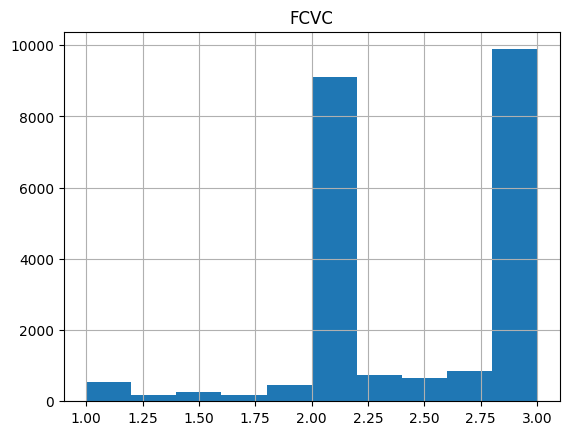

In [16]:
dft.hist('FCVC')

In [17]:
def rounder(value:float)->int:
    if value-int(value) <= 0.5:
        rounded_value = int(np.floor(value))
    elif value-int(value) > 0.5:
        rounded_value = int(np.ceil(value))
    else:
        rounded_value = int(value)

    return rounded_value

In [18]:
dft['FCVC'] = dft['FCVC'].apply(rounder)

In [19]:
dft['FCVC'].value_counts()

FCVC
3    11088
2    10923
1      857
Name: count, dtype: int64

array([[<Axes: title={'center': 'NCP'}>]], dtype=object)

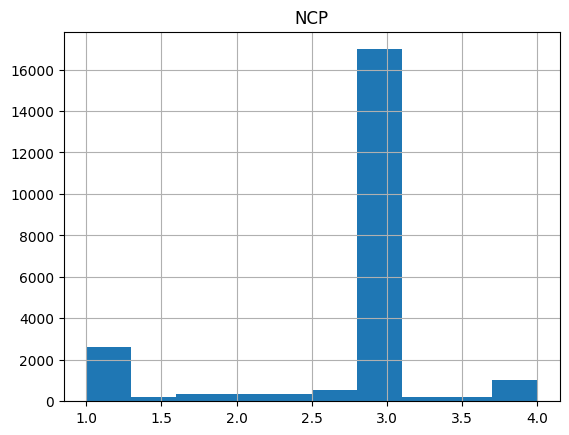

In [20]:
dft.hist('NCP')

In [21]:
dft['NCP'] = dft['NCP'].apply(rounder)

In [22]:
dft['NCP'].value_counts()

NCP
3    17779
1     2825
4     1189
2     1075
Name: count, dtype: int64

In [23]:
dft['CAEC'].value_counts()

CAEC
Sometimes     19294
Frequently     2713
Always          531
no              330
Name: count, dtype: int64

In [24]:
dft['CAEC'] = dft['CAEC'].map({'Sometimes':0,'Frequently':1,'Always':2,'no':3})

In [25]:
dft['SMOKE'].value_counts()

SMOKE
no     22579
yes      289
Name: count, dtype: int64

In [26]:
dft['SMOKE'] = dft['SMOKE'].map({'no':0,'yes':1})

array([[<Axes: title={'center': 'CH2O'}>]], dtype=object)

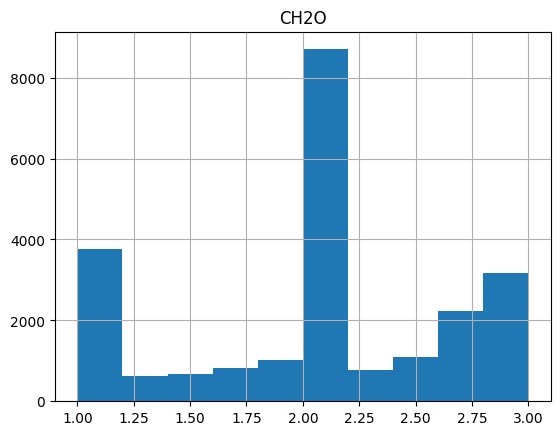

In [27]:
dft.hist('CH2O')

In [28]:
def water_mapper(value:float)->float:
    accepted_vals = [0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
    decimal_value = value - int(value)
    if value not in accepted_vals:
        if decimal_value < 0.25:
            abs1 = abs(0-decimal_value)
            abs2 = abs(0.25-decimal_value)
            decimal_part = 0 if abs1<abs2 else 0.25
            water_value = int(value) + decimal_part
        elif decimal_value > 0.25 and decimal_value < 0.5:
            abs1 = abs(0.25-decimal_value)
            abs2 = abs(0.5-decimal_value)
            decimal_part = 0.25 if abs1<abs2 else 0.5
            water_value = int(value) + decimal_part
        elif decimal_value > 0.5 and decimal_value < 0.75:
            abs1 = abs(0.5-decimal_value)
            abs2 = abs(0.75-decimal_value)
            decimal_part = 0.5 if abs1<abs2 else 0.75
            water_value = int(value) + decimal_part
        elif decimal_value > 0.75:
            abs1 = abs(0.75-decimal_value)
            abs2 = abs(1-decimal_value)
            decimal_part = 0.75 if abs1<abs2 else 1
            water_value = int(value) + decimal_part
    else:
        water_value = value

    return water_value

In [29]:
dft['CH2O'] = dft['CH2O'].apply(water_mapper)

In [30]:
dft['SCC'].value_counts()

SCC
no     22085
yes      783
Name: count, dtype: int64

In [31]:
dft['SCC'] = dft['SCC'].map({'no':0,'yes':1})

In [32]:
dft['FAF'].value_counts()

FAF
0.000000    5455
1.000000    4330
2.000000    2574
3.000000     875
1.097905      58
            ... 
2.094479       1
1.305632       1
1.949080       1
0.455422       1
1.094035       1
Name: count, Length: 1408, dtype: int64

array([[<Axes: title={'center': 'FAF'}>]], dtype=object)

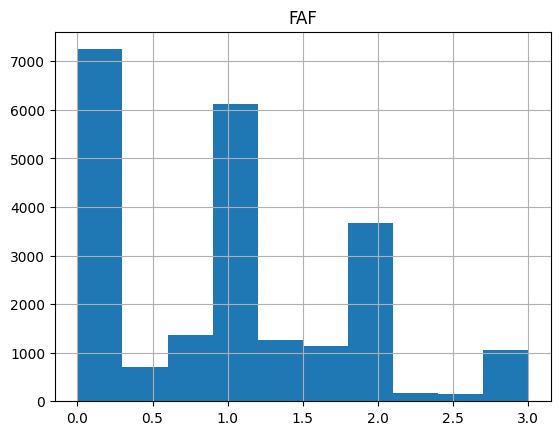

In [33]:
dft.hist('FAF')

In [34]:
dft['FAF'] = dft['FAF'].apply(rounder)

<Axes: >

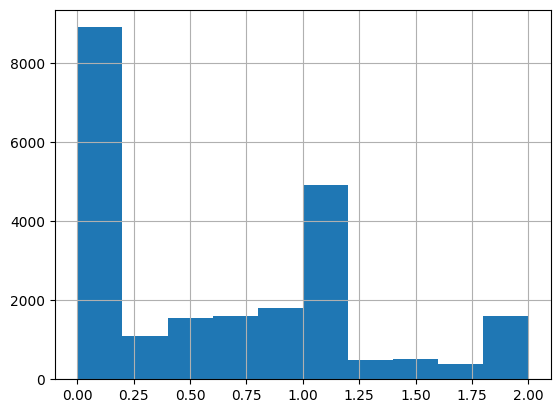

In [35]:
dft['TUE'].hist()

In [36]:
dft['TUE'] = dft['TUE'].apply(rounder)

In [37]:
dft['CALC'].value_counts()

CALC
Sometimes     16467
no             5802
Frequently      599
Name: count, dtype: int64

In [38]:
dft['CALC'] = dft['CALC'].map({'Sometimes':0,'no':1,'Frequently':1})

In [39]:
dft['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_III       4370
Obesity_Type_II        3545
Normal_Weight          3368
Obesity_Type_I         3261
Overweight_Level_II    2812
Insufficient_Weight    2795
Overweight_Level_I     2717
Name: count, dtype: int64

In [40]:
target_col_map = {
    'Insufficient_Weight':0,
    'Normal_Weight':1,
    'Overweight_Level_I':2,
    'Overweight_Level_II':3,
    'Obesity_Type_I':4,
    'Obesity_Type_II':5,
    'Obesity_Type_III':6
}

In [41]:
dft['NObeyesdad'] = dft['NObeyesdad'].map(target_col_map)

In [42]:
dft.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,Gender_Female,Gender_Male
0,24,1.70,81.67,0,0,2,3,0,0,2.75,0,0,1,0,3,0.0,1.0
1,18,1.56,57.00,0,0,2,3,1,0,2.00,0,1,1,1,1,1.0,0.0
2,18,1.71,50.17,0,0,2,1,0,0,2.00,0,1,2,1,0,1.0,0.0
3,21,1.71,131.27,0,0,3,3,0,0,1.75,0,1,1,0,6,1.0,0.0
4,31,1.91,93.80,0,0,3,2,0,0,2.00,0,2,1,0,3,0.0,1.0


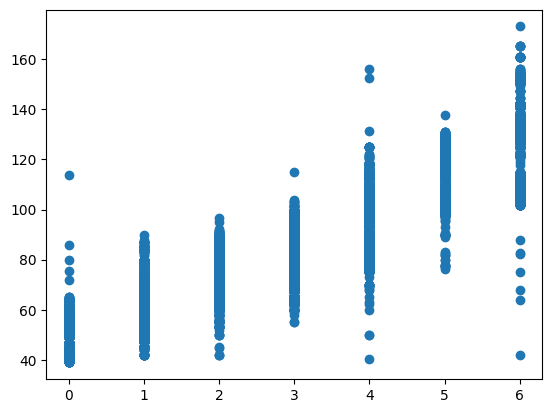

In [43]:
plt.scatter(dft['NObeyesdad'].values,dft['Weight'].values)

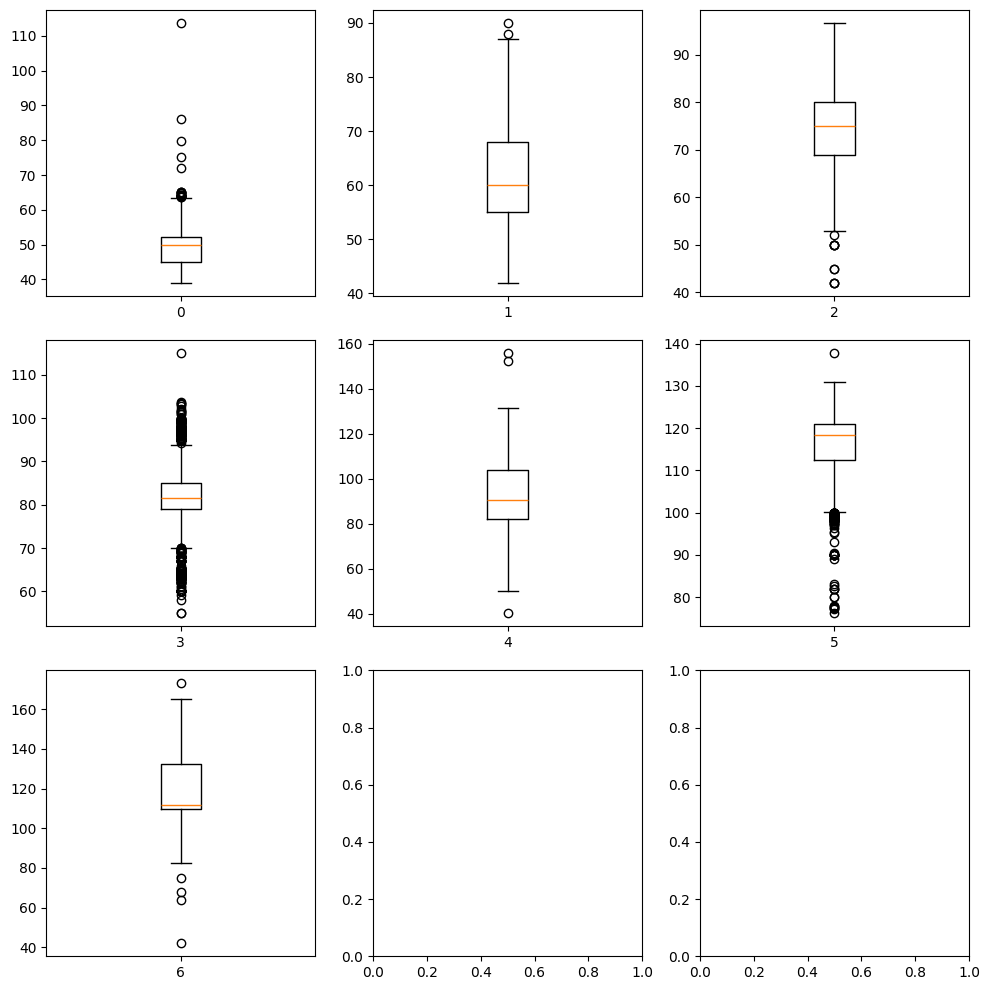

In [44]:
from itertools import product
figure,axes = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
indices = list(product(range(3),range(3)))
for i in zip(range(7),indices):
    idf = dft.loc[dft['NObeyesdad']==i[0]]['Weight'].copy()
    axes[i[1]].boxplot(idf)
    axes[i[1]].set_xticklabels([i[0]])
    
plt.tight_layout()
plt.show()

In [45]:
len(dft.loc[(dft['NObeyesdad']==0)&(dft['Weight']>70)])

5

In [46]:
dft.drop(dft.loc[(dft['NObeyesdad']==0)&(dft['Weight']>70)].index,inplace=True)

In [47]:
len(dft.loc[(dft['NObeyesdad']==1)&(dft['Weight']>87)])

2

In [48]:
dft.drop(dft.loc[(dft['NObeyesdad']==1)&(dft['Weight']>87)].index,inplace=True)

In [49]:
len(dft.loc[(dft['NObeyesdad']==2)&(dft['Weight']<50)])

6

In [50]:
dft.drop(dft.loc[(dft['NObeyesdad']==2)&(dft['Weight']<50)].index,inplace=True)

In [51]:
len(dft.loc[(dft['NObeyesdad']==3)&((dft['Weight']<60) | (dft['Weight']>110))])

5

In [52]:
dft.drop(dft.loc[(dft['NObeyesdad']==3)&((dft['Weight']<60) | (dft['Weight']>110))].index,inplace=True)

In [53]:
len(dft.loc[(dft['NObeyesdad']==4)&((dft['Weight']<50) | (dft['Weight']>140))])

3

In [54]:
dft.drop(dft.loc[(dft['NObeyesdad']==4)&((dft['Weight']<50) | (dft['Weight']>140))].index,inplace=True)

In [55]:
len(dft.loc[(dft['NObeyesdad']==5)&(dft['Weight']<90)])

16

In [56]:
dft.drop(dft.loc[(dft['NObeyesdad']==5)&(dft['Weight']<90)].index,inplace=True)

In [57]:
len(dft.loc[(dft['NObeyesdad']==6)&(dft['Weight']<80)])

4

In [58]:
dft.drop(dft.loc[(dft['NObeyesdad']==6)&(dft['Weight']<80)].index,inplace=True)

In [59]:
len(df) - len(dft)

41

In [60]:
len(dft)/6

3804.5

In [61]:
dft.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,Gender_Female,Gender_Male
0,24,1.70,81.67,0,0,2,3,0,0,2.75,0,0,1,0,3,0.0,1.0
1,18,1.56,57.00,0,0,2,3,1,0,2.00,0,1,1,1,1,1.0,0.0
2,18,1.71,50.17,0,0,2,1,0,0,2.00,0,1,2,1,0,1.0,0.0
3,21,1.71,131.27,0,0,3,3,0,0,1.75,0,1,1,0,6,1.0,0.0
4,31,1.91,93.80,0,0,3,2,0,0,2.00,0,2,1,0,3,0.0,1.0


In [62]:
mods_dict = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'xgboost': xgb.XGBClassifier(random_state=42),
    'lightboost': lgb.LGBMClassifier(random_state=42)
}

In [63]:
mod_scores_dict = {}

In [64]:
X = dft.drop(['NObeyesdad'],axis=1)
y = dft['NObeyesdad'].copy()

In [65]:
# for key in tqdm(mods_dict):
#     for scaler in [StandardScaler(),MinMaxScaler(),RobustScaler()]:
#         model = mods_dict[key]
#         cv_obj = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
#         mod_pipe = Pipeline(
#             steps=[
#                 ('scaling',scaler),
#                 ('model',model)
#             ]
#         )
#         cv_results = cross_validate(mod_pipe,X,y,scoring=['accuracy','f1_micro','roc_auc_ovr','roc_auc_ovo'],cv=cv_obj,n_jobs=8)
#         result = {}

#         for item in cv_results:
#             result[item] = cv_results[item].mean()

#         mod_scores_dict[f'{key}_{scaler}'] = result

In [66]:
# mod_results = pd.DataFrame(mod_scores_dict)

In [67]:
# def highlight_max_min(s):
#     is_max = s == s.max()
#     is_min = s == s.min()
#     return ['background-color: red' if v else 'background-color: coral' if m else '' for v, m in zip(is_max, is_min)]

In [68]:
# styled_df = mod_results.transpose().style.apply(highlight_max_min)

In [70]:
# mod_results.transpose().style.background_gradient(cmap='Greens',vmax=1,vmin=0).apply(highlight_max_min)

,fit_time,score_time,test_accuracy,test_f1_micro,test_roc_auc_ovr,test_roc_auc_ovo
DecisionTreeClassifier_StandardScaler(),0.069012,0.033855,0.853550,0.853550,0.908676,0.907430
DecisionTreeClassifier_MinMaxScaler(),0.059369,0.033997,0.853550,0.853550,0.908665,0.907418
DecisionTreeClassifier_RobustScaler(),0.067709,0.036464,0.853200,0.853200,0.908442,0.907191
RandomForestClassifier_StandardScaler(),1.503556,0.148443,0.903097,0.903097,0.987702,0.986479
RandomForestClassifier_MinMaxScaler(),1.515628,0.148397,0.903360,0.903360,0.987718,0.986496
RandomForestClassifier_RobustScaler(),1.533856,0.145837,0.903491,0.903491,0.987762,0.986541
AdaBoostClassifier_StandardScaler(),0.773845,0.083334,0.426600,0.426600,0.769697,0.781158
AdaBoostClassifier_MinMaxScaler(),0.770203,0.091694,0.426600,0.426600,0.769697,0.781158
AdaBoostClassifier_RobustScaler(),0.770266,0.098979,0.426600,0.426600,0.769697,0.781158
GradientBoostingClassifier_StandardScaler(),10.532302,0.108895,0.907390,0.907390,0.987877,0.986712


In [71]:
# def objective_xgb(trial):
#     cv_obj = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
#     params = dict(
#         n_estimators = trial.suggest_int('n_estimators',100,500),
#         max_leaves = trial.suggest_int('max_leaves',2,128),
#         max_depth = trial.suggest_int('max_depth',2,32),
#         learning_rate = trial.suggest_float('learning_rate',0.0001,0.2),
#         min_child_weight = trial.suggest_float('min_child_weight',0.1,10),
#         gamma = trial.suggest_float('gamma',0.001,5),
#         subsample = trial.suggest_float('subsample',0.1,1),
#         colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1),
#         reg_alpha = trial.suggest_float('reg_alpha',0.0001,1),
#         reg_lambda = trial.suggest_float('reg_lambda',0.0001,1)
#     )

#     model = xgb.XGBClassifier(random_state=0,**params)

#     mod_pipe = Pipeline(
#         steps=[
#                 ('scaling',RobustScaler()),
#                 ('model',model)
#             ]
#     )

#     score = cross_val_score(mod_pipe,X,y,scoring='accuracy',cv=cv_obj,n_jobs=-1)

#     return np.mean(score)

In [72]:
# study_xgb = optuna.create_study(direction='maximize',storage='sqlite:///study_xgb.db',study_name='xgb')

[I 2024-05-22 13:03:35,891] A new study created in RDB with name: xgb


In [ ]:
# study_xgb.optimize(objective_xgb,n_trials=500,n_jobs=8,show_progress_bar=True)

In [74]:
# study_xgb.best_params

{'n_estimators': 487,
 'max_leaves': 49,
 'max_depth': 8,
 'learning_rate': 0.02908997375000365,
 'min_child_weight': 3.2323757201747445,
 'gamma': 0.03885029777651042,
 'subsample': 0.49277881770678167,
 'colsample_bytree': 0.6377228688391385,
 'reg_alpha': 0.38644252432386983,
 'reg_lambda': 0.6685527048138652}

{'n_estimators': 487,  
 'max_leaves': 49,  
 'max_depth': 8,  
 'learning_rate': 0.02908997375000365,  
 'min_child_weight': 3.2323757201747445,  
 'gamma': 0.03885029777651042,  
 'subsample': 0.49277881770678167,  
 'colsample_bytree': 0.6377228688391385,  
 'reg_alpha': 0.38644252432386983,  
 'reg_lambda': 0.6685527048138652}  

 0.9143556152478912  

In [75]:
# study_xgb.best_value

0.9143556152478912

In [71]:
# def objective_lgb(trial):
#     cv_obj = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
#     params = dict(
#         n_estimators = trial.suggest_int('n_estimators',100,500),
#         num_leaves = trial.suggest_int('max_leaves',2,128),
#         max_depth = trial.suggest_int('max_depth',2,32),
#         learning_rate = trial.suggest_float('learning_rate',0.0001,0.2),
#         min_child_weight = trial.suggest_float('min_child_weight',0.1,10),
#         min_child_samples = trial.suggest_int('min_child_samples',2,100),
#         subsample = trial.suggest_float('subsample',0.1,1),
#         colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1),
#         reg_alpha = trial.suggest_float('reg_alpha',0.0001,1),
#         reg_lambda = trial.suggest_float('reg_lambda',0.0001,1)
#     )

#     model = lgb.LGBMClassifier(random_state=0,**params)

#     mod_pipe = Pipeline(
#         steps=[
#                 ('scaling',RobustScaler()),
#                 ('model',model)
#             ]
#     )

#     score = cross_val_score(mod_pipe,X,y,scoring='accuracy',cv=cv_obj,n_jobs=-1)

#     return np.mean(score)

In [72]:
# study_lgb = optuna.create_study(direction='maximize',storage='sqlite:///study_lgb.db',study_name='lgb',load_if_exists=True)

[I 2024-05-22 14:56:34,439] A new study created in RDB with name: lgb


In [ ]:
# study_lgb.optimize(objective_lgb,n_trials=500,n_jobs=8,show_progress_bar=True)

In [74]:
# study_lgb.best_params

{'n_estimators': 344,
 'max_leaves': 64,
 'max_depth': 30,
 'learning_rate': 0.024004536127053,
 'min_child_weight': 2.157434806835596,
 'min_child_samples': 47,
 'subsample': 0.9062929959278163,
 'colsample_bytree': 0.49896234420716185,
 'reg_alpha': 0.07988733882802601,
 'reg_lambda': 0.3645471059021414}

{'n_estimators': 344,  
 'max_leaves': 64,  
 'max_depth': 30,  
 'learning_rate': 0.024004536127053,  
 'min_child_weight': 2.157434806835596,  
 'min_child_samples': 47,  
 'subsample': 0.9062929959278163,  
 'colsample_bytree': 0.49896234420716185,  
 'reg_alpha': 0.07988733882802601,  
 'reg_lambda': 0.3645471059021414}  

 0.9140926649818321  

In [ ]:
# study_lgb.best_value

In [69]:
xgb_tuned_params = {'n_estimators': 487,
                    'max_leaves': 49,
                    'max_depth': 8,
                    'learning_rate': 0.02908997375000365,
                    'min_child_weight': 3.2323757201747445,
                    'gamma': 0.03885029777651042,
                    'subsample': 0.49277881770678167,
                    'colsample_bytree': 0.6377228688391385,
                    'reg_alpha': 0.38644252432386983,
                    'reg_lambda': 0.6685527048138652}

lgb_tuned_params = {'n_estimators': 344,
                    'num_leaves': 64,
                    'max_depth': 30,
                    'learning_rate': 0.024004536127053,
                    'min_child_weight': 2.157434806835596,
                    'min_child_samples': 47,
                    'subsample': 0.9062929959278163,
                    'colsample_bytree': 0.49896234420716185,
                    'reg_alpha': 0.07988733882802601,
                    'reg_lambda': 0.3645471059021414}

In [70]:
vc_model = VotingClassifier(
    estimators=[
        ('xgboost',xgb.XGBClassifier(random_state = 0, **xgb_tuned_params)),
        ('lightboost',lgb.LGBMClassifier(random_state = 0, **lgb_tuned_params))
    ],
    voting = 'soft',
    n_jobs= 8
)

In [71]:
final_model = Pipeline(
    steps=[
        ('scaler',RobustScaler()),
        ('voting_classifier',vc_model)
    ]
)

In [69]:
final_model.fit(X,y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('voting_classifier',
                 VotingClassifier(estimators=[('xgboost',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.6377228688391385,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=0....
                                                             random_state=0, ...)),
                                              ('lightboost',
                                               LGBMClassifier(colsample_bytree=0.49896234420716185,
                                                              learning_rate=0.024004536127053,
                                                              max_depth=30,
                                                              min_child_samples=47,
                                                              min_child_weight=2.157434806835596,
                                                              n_estimators=344,
                                                              num_leaves=64,
                                                              random_state=0,
                                                              reg_alpha=0.07988733882802601,
                                                              reg_lambda=0.3645471059021414,
                                                              subsample=0.9062929959278163))],
                                  n_jobs=8, voting='soft'))])

In [70]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [3]:
a = 'no'
b = 0 if a == 'yes' else 1

In [4]:
b

1